# Predictors of Good Sleep: Executive Summary

My husband has been tracking his sleep with the [Sleep as Android](http://sleep.urbandroid.org/) app for the past ~3.5 years.
One of the app's main features is recording movement (accelerometric data) during sleep, from which sleep cycles and periods of deep sleep are determined.
Users can additionally input tags (e.g., `#alcohol`, `#hot`) and a 1-5 star rating for each sleep.

As self-proclaimed "sleep coach", I analyzed this data for any insights that could improve his quality of sleep.
I quantified sleep quality in two ways:
1. Objective metric: Hours of deep sleep
    * This metric was derived from hours of sleep and % deep sleep
2. Subjective metric: Rating of sleep
    * Because of the lack of variation in ratings (they're discrete with 0.5 star increments, and the majority of sleep was rated 3.5 stars), I decided that it would be more useful to explore ratings as a binary class, with sleep rated higher than 3.5 defined as 'good' sleep
    * What makes him feel like he got a good night's sleep? Does the answer differ from the objective case?

After some feature engineering (_e.g.,_ deviations from the 'ideal' 10pm bedtime, amount of movement recorded in the first / last 90 min of sleep, hours slept the day before, etc) and exploratory analysis, some interesting patterns emerged. For example:
* There was a slightly positive correlation between today's hours of deep sleep and hours of deep sleep from a day or two days ago 
    * This implies that there are stretches or phases of 'good sleep' and 'bad sleep'
* He had more hours of deep sleep after moving to the PT timezone (from ET) even though the total hours slept were similar
    * He suspects this is because he sleeps better in cooler temperatures -- which is actually in line with how much more consistently he got deep sleep in the winter of '16/'17 in the ET timezone when the thermostat was set much lower than in  previous winters (inside knolwedge, _NOT_ reflected in the data)
    * However, sleeps in PT were not necessarily rated higher

For **deep sleep** predictive modeling (objective metric), 
* I performed LASSO, OLS (using LASSO as a feature selection method to select the top 10 features), Ridge, Principal Components Regression, and Partial Least Squares 
    * Among these, OLS (post LASSO) performed the best 
* I also trained gradient boosting and random forest models, and in the end, random forest was the winner, but it was really just the tallest of the midgets
    * All models struggled to predict lower amounts of deep sleep, but they were better at predicting higher amounts
    * The gradient boosting trees model was on average 6.7 minutes more accurate than a baseline model which simply predicts the mean outcome (13% improvement)
    * Given that the average deep sleep is 3.7 hrs or 224.5 min, the attained RMSE of 45.65 min is quite large
* Actionable predictors of getting more deep sleep are:
    * Staying in the PT timezone (presumably driven by the cooler nighttime temperatures)
    * Going to bed earlier
        * According to the feature contribution plot in the random forest model (which shows how much the feature contributes to the predicted values), the earlier the bedtime the better, even way before 10pm
            * The bedtime feature starts to contribute negatively to deep sleep around a bedtime of 10:25pm

For **sleep rating** classification (subjective metric),
* Logistic regression, gradient boosting, and random forest performed neck-and-neck in ROC and precision-recall AUCs, and none of them stood out as the clear winner:

| Logistic | Gradient boost | Random forest
--- | --- | --- | ---
ROC AUC | 0.66 | 0.67 | 0.66
Precision-recall AUC | 0.59 | 0.61 | 0.61
True positive rate (Recall) | 0.59 | 0.47 | 0.30
False positive rate | 0.38 | 0.25 | 0.05
Precision | 0.47 | 0.51 | 0.76
Accuracy | 0.61 | 0.65 | 0.71

* Predictors of subpar sleep rating:
    * Movement (tossing & turning) in the first and last stretches of sleep
        * According to the logistic model, movement in the last 90 minutes of sleep negatively affects rating to a greater extent than movement in the first 90 minutes (which intuitively makes sense)
    * Drinking alcohol, having leg aches, and feeling hot:
        * Feeling hot is slightly correlated with tossing & turning in the first 90 minutes of sleep
    * Going to bed 50 minutes past 10pm (according to the feature contribution plot in the random forest model)
* Predictors of good sleep rating:
    * Hours of deep sleep
    * Caffeine and junkfood consumption to a small extent
        * The positive effect of junkfood was unexpected; it may be that junkfood is associated with satiety (hunger is a strong sleep disturbant)

The objective metric for sleep quality, hours of deep sleep, turned out to be the biggest factor in sleep rating classification. 
Unlike in deep sleep modelling, user tags were more helpful in determining good sleep ratings. 
For example, alcohol did not affect deep sleep, but it made him feel like he didn't get a good night's sleep (alcohol is known to reduce the quality of sleep, although this does not show up in the movement data). 
Also, whereas earlier bedtimes corresponded to more deep sleep, going to bed as late as 10:50pm did not hurt ratings.

Due to the **inherent noise** in the data, no model performed well in predicting deep sleep or rating, and I don't think the app is particularly useful in predicting good sleep.
Although some actionable insights on improving sleep quality were extracted from the data (such as going to bed early and restricting alcohol consumption), these were mostly **expected findings**, and even then their **effects were pretty small**.
The biggest takeaway based on the available data is that **sleep is very random, and most factors don't matter much**.
This _non-finding_ was in fact good news for my husband -- he was happy to hear that most things aren't worth worrying about.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import scale, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline

import statsmodels.formula.api as smf

from patsy import dmatrix
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.dates as mdates
import seaborn as sns

idx = pd.IndexSlice
%matplotlib inline
plt.style.use('seaborn-white')

# Data Setup / Cleaning

In [2]:
raw_df = pd.read_csv('/home/darby/Downloads/Sleep as Android Data_mod.csv')
raw_df.dropna(subset=['Id'], axis=0, inplace=True)
raw_df.reset_index(drop=True, inplace=True)
collist1 = raw_df.columns[:15]

df_main = raw_df.loc[raw_df.Id != 'Id', collist1]
df_main.reset_index(drop=True, inplace=True)
df_main = df_main.apply(pd.to_numeric, errors='ignore')
df_main[['From', 'To']] = df_main[['From', 'To']].apply(lambda x: pd.to_datetime(x, dayfirst=True))
df_main.Id = df_main.Id.apply(pd.to_datetime, unit='ms')
df_main['Tz'] = pd.factorize(df_main.Tz)[0] # 1 is EST, 0 is PST

#  converts UTC to local time and then removes timezone in order to keep datetime64[ns] dtype
def row_tz_convert(row, col):
    if row['Tz'] == 1:
        converted = row[col].tz_localize('utc').tz_convert('US/Eastern')
        return converted.tz_localize(None)
    elif row['Tz'] == 0:
        converted = row[col].tz_localize('utc').tz_convert('US/Pacific')
        return converted.tz_localize(None)
    else:
        return 'error'
    
df_main.Id = df_main.apply(lambda x: row_tz_convert(x, 'Id'), axis=1)

# add feature: hours of deep sleep
df_main['hours_deep'] = df_main.DeepSleep * df_main.Hours

# add feature: delta from 'ideal' 10pm bedtime
pm_mask = df_main.From.dt.strftime('%p') == 'PM'
df_main.loc[pm_mask, 'ideal_bedtime'] = df_main.From.dt.strftime('%Y-%m-%d') + ' 22:00'
df_main.loc[~pm_mask, 'ideal_bedtime'] = (df_main.From - timedelta(days=1)).dt.strftime('%Y-%m-%d') + ' 22:00'
df_main.ideal_bedtime = df_main.ideal_bedtime.apply(pd.to_datetime)

past_ideal = df_main.From >= df_main.ideal_bedtime
df_main.loc[past_ideal, 'from_10p'] = df_main.Id - df_main.ideal_bedtime
df_main.loc[~past_ideal, 'from_10p'] = df_main.ideal_bedtime - df_main.Id

def time_to_num(time_delta):
    hh, mm , ss = map(float, str(time_delta).split(' ')[2].split(':'))
    return mm + 60*hh + ss/60

df_main.from_10p = df_main.from_10p.apply(time_to_num)
df_main.loc[~past_ideal, 'from_10p'] = -df_main.from_10p
del df_main['ideal_bedtime'] 

df_main.set_index(['Id'], inplace=True)
df_main.sort_index(inplace=True)

In [3]:
# tally comments
hc = df_main[df_main.Comment.notnull()].Comment.str.split('#')
hcc = []
for c in np.arange(len(hc)):
    hcc += hc[c]
hcc.sort()

hcc_dict = np.unique([string.strip() for string in hcc])
df_comments = pd.DataFrame(columns=hcc_dict[5:], index=df_main.index)

df_main.loc[df_main.Comment.notnull(), 'comment_filled'] = df_main.Comment
df_main.loc[df_main.Comment.isnull(), 'comment_filled'] = 'nc'
df_main.loc[df_main.comment_filled.str.contains('Cold nights'), 'comment_filled'] = '#cold' # manual update
df_main.comment_filled.replace('#legaches', '#legache', inplace=True) # manual update

def c_tally(col, comments):
    col_tally = 0
    for comment in comments.split('#'):
        if col == comment.strip():
            col_tally += 1
        else:
            col_tally += 0
    return col_tally

for col in df_comments.columns:
    for i in df_main.index:
        df_comments.loc[i, col] = c_tally(col, df_main.loc[i, 'comment_filled'])

# for _2x and _3x comments
col_intensifier = [col for col in df_comments.columns if ('_') in col]

"""
def c_intensify(col):
    if col.endswith('2x'):
        return 2
    elif col.endswith('3x'):
        return 3
    else:
        return 'error'

for col in col_intensifier:
    for i in df_comments[df_comments[col] == 1].index:
        df_comments.loc[i, col[:-3]] = c_intensify(col)
"""        

for col in col_intensifier:
    for i in df_comments[df_comments[col] == 1].index:
        df_comments.loc[i, col[:-3]] = 1

comments_tallied = pd.DataFrame({'counts': df_comments.sum(axis=0)})
""" 
# for checking if code for tallying comments in df_comments is working correctly
unique, counts = np.unique([string.strip() for string in hcc], return_counts=True)
true_counts = pd.DataFrame(index=unique, data=counts, columns=['true_counts'])
comments_tallied.join(true_counts, how='left')
"""
c_relevant = comments_tallied[comments_tallied.counts >= 5].index.difference(col_intensifier + ['geo0', 'geo1', 'fullmoon', 'newmoon', 'home'])

df_comments.set_index(df_comments.index.date, inplace=True)

In [4]:
collist2 = raw_df.columns[0:4].append(raw_df.columns.difference(collist1)) # include Id, Tz, To, and From
detailed_sleep_raw = raw_df.loc[:, collist2]

def name_convert(df_tz):
    if df_tz == 'America/New_York':
        return 'US/Eastern'
    elif df_tz == 'America/Los_Angeles':
        return 'US/Pacific'
    else:
        return 'error'
    
a1_list = list()
a2_list = list()
for i in np.arange(len(detailed_sleep_raw), 0, -2): # for each night's sleep
    a = pd.DataFrame(detailed_sleep_raw.iloc[i-2:i, :]).dropna(axis=1)
    a = a.T

    # time-stamped accelerometric (actigraphic) data
    a1 = a.loc[a.iloc[:, 0] != 'Event'].copy()
    a1['Id'] = a1.iloc[0, 1]
    a_tz = a1.iloc[1, 1]
    a_from = datetime.strptime(a1.iloc[2, 1], '%d. %m. %Y %H:%M')
    a_to = datetime.strptime(a1.iloc[3, 1],'%d. %m. %Y %H:%M')
    a1.drop(a1.index[0:4], axis=0, inplace=True)

    a1.Id = a1.Id.apply(pd.to_datetime, unit='ms')
    a1.Id = a1.Id.dt.tz_localize('utc').dt.tz_convert(name_convert(a_tz)).dt.tz_localize(None)
    a1.rename(columns={i-2: 'Time', i-1:'Accelo'}, inplace=True)

    pm_mask = a1.Time.str.contains('PM')
    if (a_tz == 'America/New_York') and (a_from.strftime('%d') == a_to.strftime('%d')):
        a1.loc[pm_mask, 'Time'] = (a1.Id - pd.Timedelta(days=1)).dt.date.astype(str) + ' ' + a1.Time
        a1.loc[~pm_mask, 'Time'] = a1.Id.dt.date.astype(str) + ' ' + a1.Time
    if a_from.strftime('%d') != a_to.strftime('%d'):
        a1.loc[pm_mask, 'Time'] = a1.Id.dt.date.astype(str) + ' ' + a1.Time
        a1.loc[~pm_mask, 'Time'] = (a1.Id + pd.Timedelta(days=1)).dt.date.astype(str) + ' ' + a1.Time

    a1.Time = a1.Time.apply(pd.to_datetime)
    if a_tz == 'America/New_York':
        a1.Time = a1.Time.dt.tz_localize('US/Pacific').dt.tz_convert(name_convert(a_tz)).dt.tz_localize(None)
    a1.Accelo = a1.Accelo.apply(pd.to_numeric)
    a1['TimeSince'] = a1.Time - a1.Id
    a1.set_index(['Id', 'TimeSince'], inplace=True)
    a1_list.append(a1)

    # time-stamped event data
    a2 = a.loc[(a.iloc[:, 0] == 'Id') | (a.iloc[:, 0] == 'Event')].copy()
    a2_id = a2.iloc[0, 1]
    a2.drop(a2.index[0:1], axis=0, inplace=True)
    a2 = pd.DataFrame(a2.iloc[:, 1].str.split('-').tolist(), columns=['Event', 'Time'])
    a2['Id'] = a2_id
    a2.Id = a2.Id.apply(pd.to_datetime, unit='ms')
    a2.Id = a2.Id.dt.tz_localize('utc').dt.tz_convert(name_convert(a_tz)).dt.tz_localize(None)
    a2.Time = a2.Time.apply(pd.to_datetime, unit='ms')
    a2.Time = a2.Time.dt.tz_localize('utc').dt.tz_convert(name_convert(a_tz)).dt.tz_localize(None)
    a2['TimeSince'] = a2.Time - a2.Id
    a2.set_index(['Id', 'TimeSince'], inplace=True)
    a2_list.append(a2)

df_accelo = pd.concat(a1_list).sort_index()
df_event = pd.concat(a2_list).sort_index()

In [5]:
# add feature: cumulative Accelo in the LAST x minutes of sleep
def last_insom(s, tail_min=45):
    cutoff = s.last_valid_index()[1] - timedelta(minutes=tail_min)
    return s.loc[idx[:, cutoff:]].sum()

accelo_last45 = df_accelo.Accelo.groupby(level=0).agg(last_insom)
accelo_last90 = df_accelo.Accelo.groupby(level=0).agg(lambda s: last_insom(s, tail_min=90))

accelo_last45.name = 'last45'
accelo_last90.name = 'last90'

# add feature: cumulative Accelo in the FIRST x minutes of sleep
def first_insom(s, head_min=45):
    cutoff = s.first_valid_index()[1] + timedelta(minutes=head_min)
    return s.loc[idx[:, :cutoff]].sum()

accelo_first45 = df_accelo.Accelo.groupby(level=0).agg(first_insom)
accelo_first90 = df_accelo.Accelo.groupby(level=0).agg(lambda s: first_insom(s, head_min=90))

accelo_first45.name = 'first45'
accelo_first90.name = 'first90'

df_main = df_main.join([accelo_last45, 
                        accelo_last90,
                        accelo_first45, 
                        accelo_first90])

In [6]:
# add feature: number of REM cycles
for i in df_main.index:
    df_main.loc[df_main.index == i, 'rem_cycles'] = np.sum(df_event.loc[i].Event.str.contains('REM'))/2

In [7]:
# remove naps from df_main before adding shifted features
df_main = df_main[df_main.Hours > 2]

# add gap days to get accurate shifted data
new_index = pd.DataFrame(index=pd.date_range('2014-04-21', '2017-09-25', freq='D'))
df_cont_main = new_index.join(df_main.set_index(df_main.index.date))

In [8]:
# add features: shifted (by 1 and 2 days) hours, hours_deep, Rating
for feature in ['Hours', 'hours_deep', 'Rating']:
    for i in [1, 2]:
        new_feature = feature + '_shft' + str(i)
        df_cont_main[new_feature] = df_cont_main[feature].shift(i)

In [9]:
# Check to see if shifted features are coded correctly
cols = list()
for col in df_cont_main.columns:
    if 'hours_deep' in col:
        cols.append(col)
df_cont_main[cols].head(10)

,hours_deep,hours_deep_shft1,hours_deep_shft2
2014-04-21,3.502222,NaN,NaN
2014-04-22,3.443125,3.502222,NaN
2014-04-23,3.503415,3.443125,3.502222
2014-04-24,3.199175,3.503415,3.443125
2014-04-25,NaN,3.199175,3.503415
2014-04-26,2.448889,NaN,3.199175
2014-04-27,2.673659,2.448889,NaN
2014-04-28,1.579592,2.673659,2.448889
2014-04-29,2.433030,1.579592,2.673659
2014-04-30,3.927711,2.433030,1.579592


In [10]:
# for hours of deep sleep analysis
for_deep = df_cont_main
for_deep.shape

(1283, 28)

In [11]:
# remove unrated sleeps -- for rating analysis
for_rating = df_cont_main[df_cont_main.Rating > 0].copy()
for_rating['above_avg'] = np.where(for_rating.Rating > 3.5, 1, 0)
for_rating.shape

(1012, 29)

# Exploratory Analysis

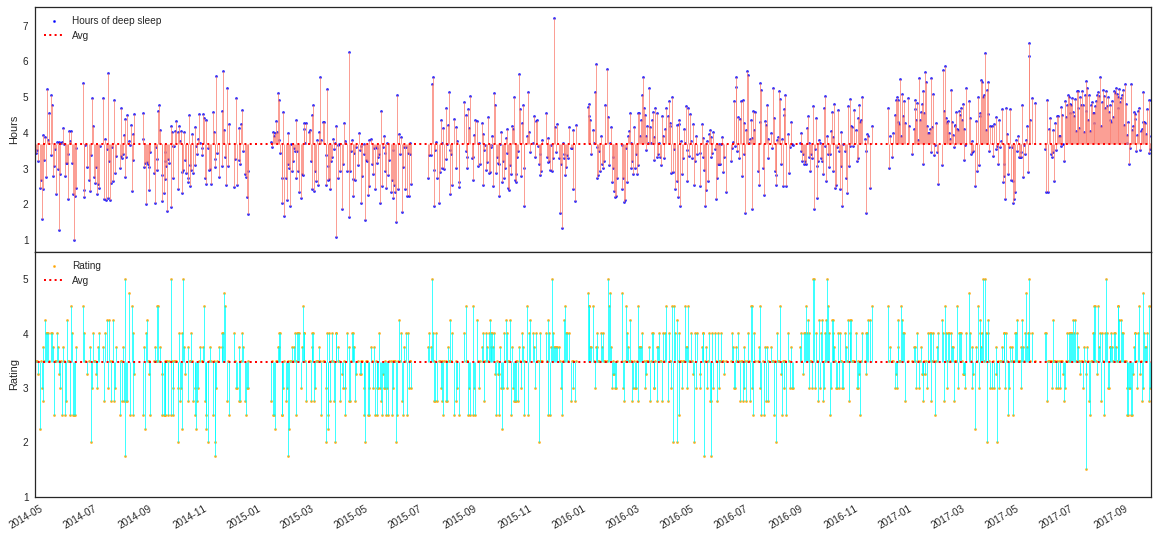

In [12]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
ax1.scatter(for_deep.index.date, for_deep.hours_deep, label='Hours of deep sleep', s=5, c='blue')
ax1.vlines(for_deep.index.date, np.mean(for_deep.hours_deep), for_deep.hours_deep, lw=0.75, colors='salmon')
ax1.hlines(np.mean(for_deep.hours_deep), '2014', '2018', label='Avg', linestyles='dotted', lw=2, colors='r')
ax1.set_ylabel('Hours')
ax1.get_xaxis().set_visible(False)
ax1.legend(loc='upper left')

ax2 = plt.subplot(gs[1], sharex=ax1)
ax2.scatter(for_rating.index.date, for_rating.Rating, label='Rating', s=5, c='orange')
ax2.vlines(for_rating.index.date, np.mean(for_rating.Rating), for_rating.Rating, lw=0.75, colors='cyan')
ax2.set_ylabel('Rating')
ax2.set_ylim(1, 5.5)
ax2.set_yticks([1, 2, 3, 4, 5])
ax2.hlines(np.mean(for_rating.Rating), '2014', '2018', label='Avg', linestyles='dotted', lw=2, colors='r')
ax2.legend(loc='upper left')

years = mdates.YearLocator()
months = mdates.MonthLocator(interval=2)
ymFmt = mdates.DateFormatter('%Y-%m')

ax2.set_xlim('2014-04-21', '2017-09-25')
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(ymFmt)

fig.autofmt_xdate()
plt.subplots_adjust(hspace=.0);

High-level glance at the data to see if there are any discernable patterns (gaps show up on days when sleep was not recorded)
* hours of deep sleep are more or less consistently above average since Jul '17
* hard to tell if getting more hours of deep sleep is associated with higher ratings

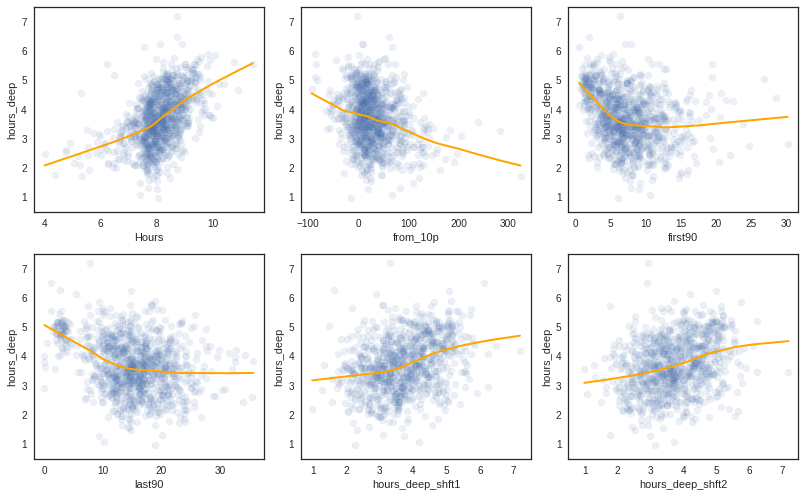

In [13]:
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(3,4)

axes = ['ax{}'.format(i) for i in np.arange(6)]
for i in np.arange(3):
    axes[i] = plt.subplot(gs[0,i])
for i in np.arange(3, 6):
    axes[i] = plt.subplot(gs[1,i-3])
    
features = ['Hours', 'from_10p', 'first90', 'last90',
            'hours_deep_shft1', 'hours_deep_shft2']

for ax, feature in zip(axes, features):
    ax.scatter(feature, 'hours_deep', data=for_deep, alpha=0.1)
    sns.regplot(feature, 'hours_deep', data=for_deep, ax=ax, scatter=False, lowess=True, 
                line_kws={'color':'orange', 'lw':2})
    ax.set_ylim(0.5, 7.5)
    
axes[5].set_xlim(0.5, 7.5)
gs.tight_layout(plt.gcf());

Relationship between `hours_deep` (_hours of deep sleep_) & certain features:
* Obviously the more hours you sleep, the more likely you are to have more hours of deep sleep
    * `Hours` will not be included in the predictive modelling of deep sleep, because it would be kind of cheating!
* Later bedtimes are associated with fewer hours of deep sleep
* Initially, `first90` and `last90` (measure of movement in the first 90 min and last 90 min of sleep, i.e., tossing and turning) negatively affect hours of deep sleep, but the effects plateau
* Interesting to observe a slightly positive relationship between hours of deep sleep and shifted hours of deep sleep (from a day/two days ago)
    * It's likely that there are stretches of 'good sleep' days and 'bad sleep' days (e.g., consecutive bad sleep days around a stressful event)

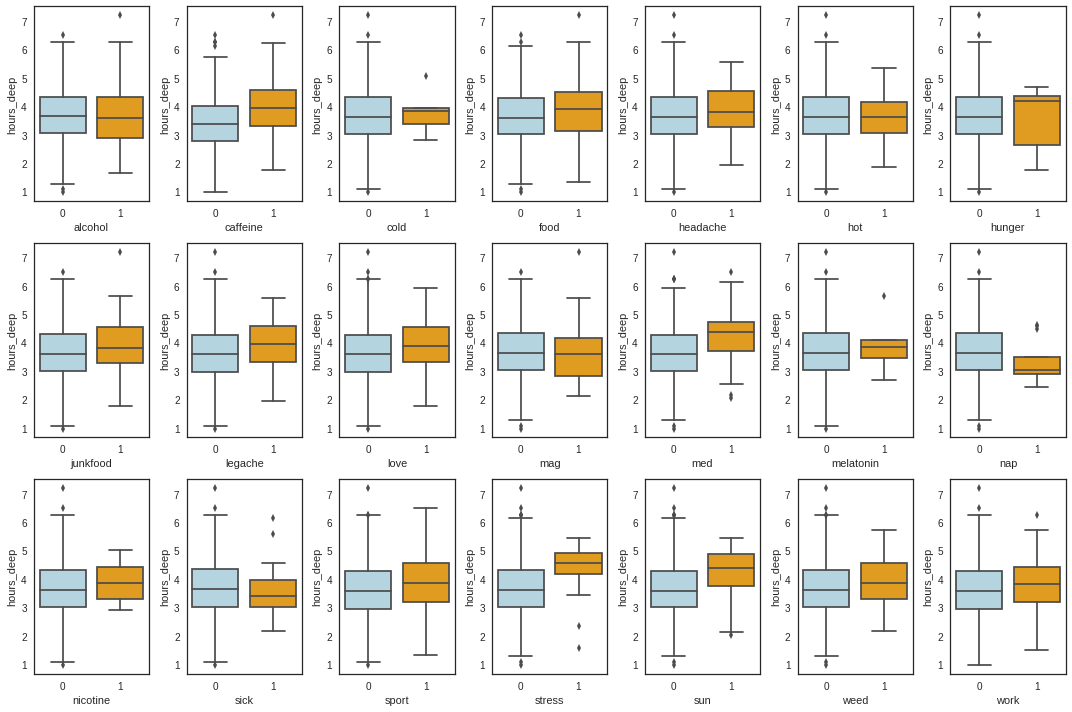

In [14]:
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(3,7)

axes = ['ax{}'.format(i) for i in np.arange(21)]
for i in np.arange(7):
    axes[i] = plt.subplot(gs[0,i])
for i in np.arange(7, 14):
    axes[i] = plt.subplot(gs[1,i-7])
for i in np.arange(14, 21):
    axes[i] = plt.subplot(gs[2,i-14])
    
c_expl = for_deep.join(df_comments[c_relevant])

c_palette = {0:'lightblue', 1:'orange'}

for i,ax in zip(np.arange(c_relevant.shape[0]), axes):
    sns.boxplot(c_expl[c_relevant[i]], c_expl.hours_deep, orient='v', ax=ax, palette=c_palette)

gs.tight_layout(plt.gcf());

User tags vs `hours_deep` (_hours of deep sleep_)
* Hard to tease out the effects here unless tags really influence sleep since I'm only looking at one variable at a time (and not controlling for all the other variables)
* Some tags appear to be associated with more/fewer hours of deep sleep
    * _E.g._, more deep sleep on days tagged with `#stress`, less deep sleep on days with naps

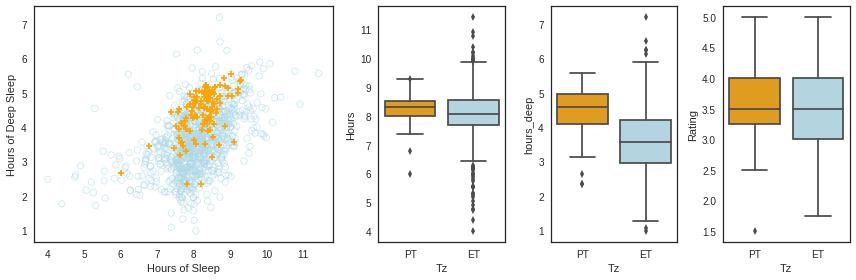

In [15]:
fig = plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1,5)
ax1 = plt.subplot(gs[0,:2])
ax2 = plt.subplot(gs[0,2])
ax3 = plt.subplot(gs[0,3])
ax4 = plt.subplot(gs[0,4])

ax1.scatter(for_deep[for_deep.Tz == 1].Hours,
            for_deep[for_deep.Tz == 1].hours_deep,
            s=40, edgecolors='lightblue', facecolors='none',
            marker='o', linewidths=1, alpha=0.5)
ax1.scatter(for_deep[for_deep.Tz == 0].Hours,
            for_deep[for_deep.Tz == 0].hours_deep,
            s=40, c='orange', marker='+', linewidths=1)
ax1.set_ylabel('Hours of Deep Sleep')
ax1.set_xlabel('Hours of Sleep')

c_palette = {1:'lightblue', 0:'orange'}

for ax, df, feature in zip([ax2, ax3, ax4], [for_deep, for_deep, for_rating], ['Hours', 'hours_deep', 'Rating']):
    sns.boxplot('Tz', feature, data=df, orient='v', ax=ax, palette=c_palette)
    ax.xaxis.set_ticklabels(['PT', 'ET'])
    
gs.tight_layout(plt.gcf());

In [16]:
print('[Avg Hours]      PT:{:.2f} '.format(np.mean(for_deep[for_deep.Tz == 0].Hours)), 
      'ET:{:.2f}'.format(np.mean(for_deep[for_deep.Tz == 1].Hours)))
print('[Avg hours_deep] PT:{:.2f} '.format(np.mean(for_deep[for_deep.Tz == 0].hours_deep)), 
      'ET:{:.2f}'.format(np.mean(for_deep[for_deep.Tz == 1].hours_deep)))
print('[Avg Rating]     PT:{:.2f} '.format(np.mean(for_rating[for_rating.Tz == 0].Rating)), 
      'ET:{:.2f}'.format(np.mean(for_rating[for_rating.Tz == 1].Rating)))

[Avg Hours]      PT:8.25  ET:8.07
[Avg hours_deep] PT:4.47  ET:3.60
[Avg Rating]     PT:3.57  ET:3.45


Getting more hours of deep sleep since moving to California!
* Difference in hours of deep sleep between ET and PT timezones is pretty big, especially compared to the difference in hours of sleep
* Despite getting noticeably more deep sleep in PT, my husband has not rated sleeps in PT higher

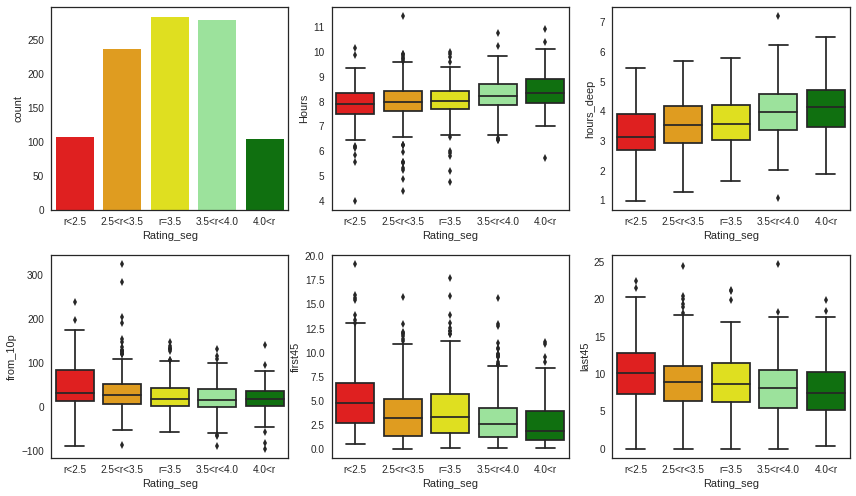

In [17]:
fig = plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(3,3)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[1,0])
ax5 = plt.subplot(gs[1,1])
ax6 = plt.subplot(gs[1,2])

rtsegs = ['r<2.5', '2.5<r<3.5', 'r=3.5', '3.5<r<4.0', '4.0<r']

for_rating.loc[for_rating.Rating > 0, 'Rating_seg'] = rtsegs[0]
for_rating.loc[for_rating.Rating > 2.5, 'Rating_seg'] = rtsegs[1]
for_rating.loc[for_rating.Rating == 3.5, 'Rating_seg'] = rtsegs[2]
for_rating.loc[for_rating.Rating > 3.5, 'Rating_seg'] = rtsegs[3]
for_rating.loc[for_rating.Rating > 4.0, 'Rating_seg'] = rtsegs[4]

c_palette = {rtsegs[0]:'red', rtsegs[1]:'orange', rtsegs[2]:'yellow', rtsegs[3]:'lightgreen', rtsegs[4]:'green'}

sns.countplot(for_rating.Rating_seg, ax=ax1, palette=c_palette, order=rtsegs)

axes = [ax2, ax3, ax4, ax5, ax6]
features = ['Hours', 'hours_deep', 'from_10p', 'first45', 'last45']
for feature, ax in zip(features, axes):
    sns.boxplot('Rating_seg', feature, data=for_rating, order=rtsegs, orient='v', ax=ax, palette=c_palette)

gs.tight_layout(plt.gcf());

Relationship between user rating & features:
* The majority of ratings are 3.5 stars (other ratings are grouped)
* Ratings appear to go up with `Hours` and `hours_deep`, whereas they go down with `from_10p`, `first45`, and `last45`

# Data Setup for Modelling

In [18]:
# features to leave out
cols_out = ['From', 'To', 'Sched', 'Rating', 'Comment', 'Framerate', 'Snore', 'Noise', 'Geo', 'comment_filled']

In [19]:
# for deep sleep analysis

df_deep = for_deep[for_deep.columns.difference(cols_out)].join(df_comments[c_relevant]).sample(frac=1, replace=False, random_state=18) # join with df containing comments & shuffle order
df_deep.dropna(axis=0, inplace=True)
df_deep = df_deep.apply(pd.to_numeric)

# leave out features that are directly related with hours of deep sleep / hours of sleep
X_d = df_deep[df_deep.columns.difference(['Hours', 'DeepSleep', 'hours_deep', 'Cycles', 'rem_cycles',
                                          'Rating_shft1', 'Rating_shft2'])] # also leave out shifted ratings
y_d = df_deep.hours_deep

# split into test / train set
X_dr, X_dt, y_dr, y_dt = train_test_split(X_d, y_d, train_size = 0.75, random_state=32)

In [20]:
for_deep.shape, df_deep.shape, X_dr.shape # lose data points due to NaN shifted data

((1283, 28), (833, 39), (624, 32))

In [21]:
# for rating analysis
# for_rating contains 'above_avg' (1 for ratings above 3.5)

df_rating = for_rating[for_rating.columns.difference(cols_out + ['Rating_seg'])].join(df_comments[c_relevant]).sample(frac=1, replace=False, random_state=32)
df_rating.dropna(axis=0, inplace=True)
df_rating = df_rating.apply(pd.to_numeric)
X_r = df_rating[df_rating.columns.difference(['above_avg', 'DeepSleep'])]
y_r = df_rating.above_avg

# split into test / train set
X_rr, X_rt, y_rr, y_rt = train_test_split(X_r, y_r, train_size = 0.75, random_state=73)

In [22]:
for_rating.shape, df_rating.shape, X_rr.shape

((1012, 30), (818, 40), (613, 38))

Variance inflation factor (VIF):
- the ratio of the variance of $\hat \beta_j$ when fitting the full model divided by the variance of $\hat \beta_j$ if fit on its own
- VIF value that exceeds 5 or 10 indicates a problematic amount of collinearity

$$ VIF(\hat \beta_j) = \frac{1}{1 - R^2_{X_j | X_{-j}}}$$
where $R^2_{X_j | X_{-j}}$ is the $R^2$ from regrssion of $X_j$ onto all the other predictors

In [23]:
formula = '+'.join(X_d.columns)
X = dmatrix(formula, data=X_d, return_type='matrix')
vif = {}

for i in range(1, X.shape[1]):
    vif[X.design_info.column_names[i]] = variance_inflation_factor(np.array(X), i)
vif_df = pd.DataFrame.from_dict(vif, orient='index')

vif_df.sort_values(0, ascending=False).head(10)

,0
first90,5.283198
first45,4.596269
last90,4.141705
last45,3.754463
Tz,1.971319
hours_deep_shft2,1.686373
hours_deep_shft1,1.668522
caffeine,1.647679
sun,1.520158
Hours_shft2,1.394513


In [24]:
formula = '+'.join(X_r.columns)
X = dmatrix(formula, data=X_r, return_type='matrix')
vif = {}

for i in range(1, X.shape[1]):
    vif[X.design_info.column_names[i]] = variance_inflation_factor(np.array(X), i)
vif_df = pd.DataFrame.from_dict(vif, orient='index')

vif_df.sort_values(0, ascending=False).head(10)

,0
first90,5.401252
first45,4.656252
last90,4.145296
hours_deep,3.839164
last45,3.769960
Cycles,2.312366
Tz,2.053022
rem_cycles,2.021254
hours_deep_shft1,1.779774
hours_deep_shft2,1.738407


first/last 90 and 45 (movement in the first/last 45 and 90 minutes of sleep) are obviously collinear 

# Deep Sleep Analysis

## Lasso

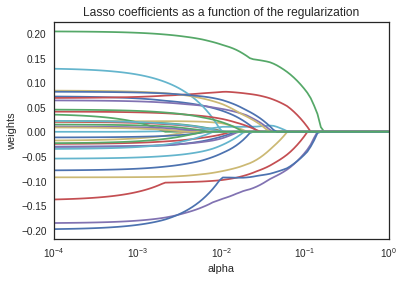

In [25]:
alphas = 10**np.linspace(-4, 0, 100)

lasso = Lasso(max_iter=10000)
coefs = []
for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_dr), y_dr)
    coefs.append(lasso.coef_)

ax = plt.gca() 
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.xlim(10**-4, 1)
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

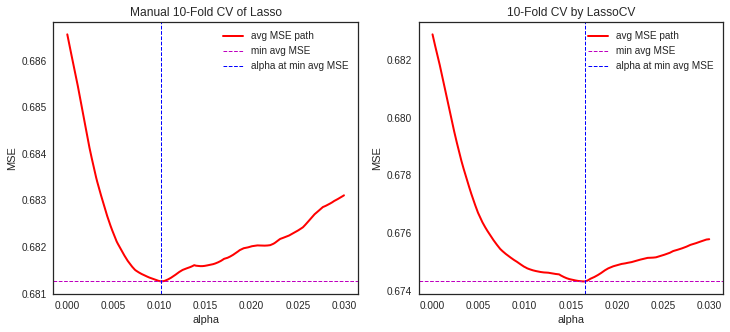

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
alphas = np.linspace(0.00001, 0.03, 500)

# ax1: 10-fold cross validation - manual version of LassoCV
# showing the manual version just as a coding exercise & to cement my understanding of how CV works
kf = KFold(n_splits=10, shuffle=False) # when True, creates new indicies for every alpha
cv_errors = []
for alpha in alphas:
    mses = []
    for train_index, test_index in kf.split(X_dr):
        X_train, X_test = X_dr.values[train_index], X_dr.values[test_index]
        y_train, y_test = y_dr.values[train_index], y_dr.values[test_index]
        reg = Lasso(alpha=alpha, max_iter=10000)
        reg.fit(scale(X_train), y_train)
        y_pred = reg.predict(scale(X_test))
        mses.append(mean_squared_error(y_test, y_pred))
    cv_errors.append(np.mean(mses))

ax1.set_title('Manual 10-Fold CV of Lasso')
ax1.plot(alphas, cv_errors, lw=2, label='avg MSE path', color='r')
ax1.axhline(np.min(cv_errors), linestyle='dashed', lw=1, color='m', label='min avg MSE')
ax1.axvline(alphas[np.argmin(cv_errors)], linestyle='dashed', lw=1, color='b', label='alpha at min avg MSE')

# ax2: 10-fold CV by LassoCV
lassocv = LassoCV(alphas=alphas, cv=10, max_iter=10000, n_alphas=500)
lassocv.fit(scale(X_dr), y_dr)

ax2.set_title('10-Fold CV by LassoCV')
ax2.plot(lassocv.alphas_, np.mean(lassocv.mse_path_, axis=-1), lw=2, label='avg MSE path', color='r')
ax2.axhline(np.min(np.mean(lassocv.mse_path_, axis=-1)), linestyle='dashed', lw=1, color='m', label='min avg MSE')
ax2.axvline(lassocv.alpha_, linestyle='dashed', lw=1, color='b', label='alpha at min avg MSE')

for ax in fig.axes:
    ax.legend()
    ax.set_xlabel('alpha')
    ax.set_ylabel('MSE');

In [27]:
-np.mean(cross_val_score(lassocv, scale(X_dr), y_dr, scoring='neg_mean_squared_error', cv=10)) # CV MSE

0.68310401415773536

In [28]:
lasso_y = lassocv.predict(scale(X_dt))
mean_squared_error(y_dt, lasso_y) # Test MSE

0.6168172995926392

In [29]:
# coefficients sorted high to low
lasso_cf = pd.DataFrame({'coeff':lassocv.coef_, 'std':np.std(X_dr)}, 
                         index=X_dr.columns)
lasso_cf['abs_coeff'] = np.abs(lasso_cf.coeff)
lasso_cf.sort_values('abs_coeff', ascending=False, inplace=True)
del lasso_cf['abs_coeff']
lasso_cf

,coeff,std
hours_deep_shft1,0.181788,0.958259
Tz,-0.142284,0.332527
last90,-0.112739,5.935610
first90,-0.099595,4.139367
from_10p,-0.083022,32.869433
hours_deep_shft2,0.079847,0.950947
weed,0.068216,0.203463
med,0.061625,0.223803
Hours_shft1,-0.050232,0.724896
food,0.049168,0.379693


* E(Y | X = x): for each 57 min (0.958) increase in yesterday's deep sleep (`hours_deep_shft1`), the average increase in today's mean deep sleep is about 11 min (0.181788)

## OLS (post Lasso)

In [30]:
# Lasso as variable selection
# Use the top 10 features from Lasso
n_lasso = 10

In [31]:
train_set = pd.concat([X_dr, y_dr], axis=1)
formula = 'hours_deep~' + '+'.join(lasso_cf.index[:n_lasso])
ols = smf.ols(formula, data=train_set).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             hours_deep   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     21.39
Date:                Sun, 05 Nov 2017   Prob (F-statistic):           2.49e-34
Time:                        08:05:24   Log-Likelihood:                -744.11
No. Observations:                 624   AIC:                             1510.
Df Residuals:                     613   BIC:                             1559.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.3664      0.414     10.558      0.000       3.554       5.179
hours_deep_shft1     0.2134      0.044      4.896      0.000       0.128       0.299
Tz                  -0.4237      0.112     -3.767      0.000      -0.645      -0.203
last90              -0.0160      0.006     -2.503      0.013      -0.029      -0.003
first90             -0.0258      0.009     -2.996      0.003      -0.043      -0.009
from_10p            -0.0030      0.001     -2.947      0.003      -0.005      -0.001
hours_deep_shft2     0.0942      0.038      2.473      0.014       0.019       0.169
weed                 0.3984      0.161      2.476      0.014       0.082       0.714
med                  0.3133      0.149      2.097      0.036       0.020       0.607
Hours_shft1         -0.1192      0.052     -2.283      0.023      -0.222      -0.017
food                 0.1950      0.087      2.251      0.025       0.025       0.365
==============================================================================
Omnibus:                        6.363   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                7.984
Skew:                           0.101   Prob(JB):                       0.0185
Kurtosis:                       3.516   Cond. No.                         551.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
ols_y = ols.predict(X_dt)
mean_squared_error(y_dt, ols_y) # test MSE

0.61207835878594463

## Ridge

In [33]:
alphas = np.linspace(154, 155, 100)
ridgecv = RidgeCV(alphas=alphas, cv=10, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_dr), y_dr)

RidgeCV(alphas=array([ 154.    ,  154.0101, ...,  154.9899,  155.    ]),
    cv=10, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='neg_mean_squared_error', store_cv_values=False)

In [34]:
ridgecv.alpha_

154.50505050505049

In [35]:
# CV MSE
-np.mean(cross_val_score(ridgecv, scale(X_dr), y_dr, scoring='neg_mean_squared_error', cv=10))

0.67428957070752227

In [36]:
ridge_y = ridgecv.predict(scale(X_dt))
mean_squared_error(y_dt, ridge_y) # test MSE

0.6190776801777913

In [37]:
# coefficients sorted high to low
ridge_cf = pd.DataFrame({'coeff':ridgecv.coef_, 'std':lasso_cf['std']}, 
                         index=lasso_cf.index)
ridge_cf['abs_coeff'] = np.abs(ridge_cf.coeff)
ridge_cf.sort_values('abs_coeff', ascending=False, inplace=True)
del ridge_cf['abs_coeff']
ridge_cf

,coeff,std
nicotine,0.154495,0.162792
first90,-0.134367,4.139367
sick,-0.109142,0.158062
Hours_shft1,-0.081772,0.724896
cold,-0.078074,0.105319
last45,0.077201,4.089569
melatonin,0.067245,0.079807
first45,0.066220,3.177159
weed,0.051033,0.203463
food,0.047115,0.379693


## Principal Components Regression

PCR is not a feature selection method
- each of the $M$ principal components used in the regression is a linear combination of all $p$ of the original features
- does not result in a model that relies upon a small set of the original features
- closely related to ridge

In [38]:
pca = PCA()
X_dr_reduced = pca.fit_transform(scale(X_dr))

In [39]:
# variance explained by the principal components
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 12.34,  18.05,  23.61,  28.43,  33.01,  37.27,  41.36,  45.3 ,
        49.15,  52.66,  56.03,  59.26,  62.44,  65.49,  68.48,  71.39,
        74.23,  76.94,  79.42,  81.85,  84.17,  86.34,  88.48,  90.51,
        92.44,  94.24,  95.85,  97.17,  98.23,  99.25,  99.68, 100.  ])

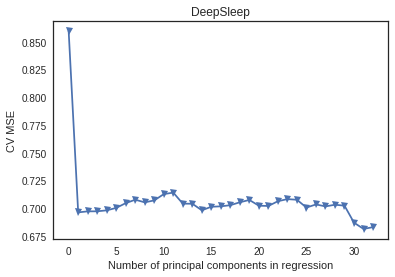

In [40]:
n = len(X_dr_reduced)
regr = LinearRegression()
pca_mse = []

# calculate MSE with only the intercept (no principal components in regression)
score = np.mean(cross_val_score(regr, np.ones((n,1)), y_dr, cv=10, scoring='neg_mean_squared_error'))
pca_mse.append(-score)

# calculate MSE using CV, adding one principal component at a time
for i in np.arange(1, X_dr.shape[1] + 1):
    score = np.mean(cross_val_score(regr, X_dr_reduced[:,:i], y_dr, cv=10, scoring='neg_mean_squared_error'))
    pca_mse.append(-score)

plt.plot(pca_mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('CV MSE')
plt.title('DeepSleep');

In [41]:
np.argmin(pca_mse) # the lowest training MSE is reached when doing regression on 31 components

31

In [42]:
# Transform test data with PCA loadings and fit regression on x principal components
X_dt_reduced = pca.transform(scale(X_dt))[:,:np.argmin(pca_mse)]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_dr_reduced[:,:np.argmin(pca_mse)], y_dr)

# Prediction with test data
pca_y = regr.predict(X_dt_reduced)
mean_squared_error(y_dt, pca_y)

0.65362613505255107

## Partial Least Squares

* A supervised alternative to PCR
* Also a dimension reduction method, which first identifies a new set of features $Z_1,...,Z_M$ that are linear combinations of the original features
* Unlike PCR, PLS identifies these new features in a supervised way - i.e., makes use of the response $Y$ in order to identify new features that not only approximate the old features well, but also that are related to the response

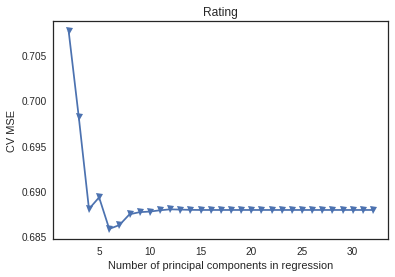

In [43]:
n = len(X_dr)
pls_mse = []

for i in np.arange(1, X_dr.shape[1] + 1):
    pls = PLSRegression(n_components=i)
    score = np.mean(cross_val_score(pls, scale(X_dr), y_dr, cv=10, scoring='neg_mean_squared_error'))
    pls_mse.append(-score)

plt.plot(np.arange(2, X_dr.shape[1] + 1), pls_mse[1:], '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('CV MSE')
plt.title('Rating');

In [44]:
np.argmin(pls_mse) + 1

6

In [45]:
pls = PLSRegression(n_components=np.argmin(pls_mse)+1)
pls.fit(scale(X_dr), y_dr)

pls_y = pls.predict(scale(X_dt))[:,0]
mean_squared_error(y_dt, pls_y)

0.65114605347879873

## Gradient Boosting Regression Trees

In [46]:
# Baseline
gbr0 = GradientBoostingRegressor(random_state=8).fit(X_dr, y_dr)
-np.mean(cross_val_score(gbr0, X_dr, y_dr, cv=10, scoring='neg_mean_squared_error'))

0.71403784816024229

In [47]:
# Baseline test MSE
mean_squared_error(y_dt, gbr0.predict(X_dt))

0.61164814886825924

In [48]:
gbr_model = Pipeline([
    ('gbr', GradientBoostingRegressor(random_state=8))
])

In [49]:
gbr_hyper_params = {
                    'gbr__learning_rate': [0.015],
                    'gbr__n_estimators': [350],
                    'gbr__max_depth': [3],
                    'gbr__min_samples_split': [7],
                    'gbr__min_samples_leaf': [2],
                    'gbr__max_features': [4],
                    'gbr__subsample': [0.8]
                   }

In [50]:
gbr_cv = GridSearchCV(gbr_model, param_grid=gbr_hyper_params, cv=10, scoring='neg_mean_squared_error')
gbr_cv.fit(X_dr, y_dr)
gbr_cv.best_params_, -gbr_cv.best_score_ # CV MSE

({'gbr__learning_rate': 0.015,
  'gbr__max_depth': 3,
  'gbr__max_features': 4,
  'gbr__min_samples_leaf': 2,
  'gbr__min_samples_split': 7,
  'gbr__n_estimators': 350,
  'gbr__subsample': 0.8},
 0.65158779836448355)

In [51]:
gbr_y = gbr_cv.predict(X_dt)
mean_squared_error(y_dt, gbr_y) # test MSE after training

0.57923432213009085

In [52]:
# for feature importance
gbr = GradientBoostingRegressor(random_state=8, learning_rate=0.015, n_estimators=350, max_depth=3, min_samples_split=7, min_samples_leaf=2, max_features=4, subsample=0.8).fit(X_dr, y_dr)

## Random Forest

In [53]:
# Baseline
rfr0 = RandomForestRegressor(random_state=25).fit(X_dr, y_dr)
-np.mean(cross_val_score(rfr0, X_dr, y_dr, cv=10, scoring='neg_mean_squared_error'))

0.76545861354462241

In [54]:
# Baseline test MSE
mean_squared_error(y_dt, rfr0.predict(X_dt))

0.65384115058021797

In [55]:
rfr_model = Pipeline([
    ('rfr', RandomForestRegressor(random_state=25))
])

In [56]:
# parameter training
rfr_hyper_params = {
                    'rfr__n_estimators': [600], 
                    'rfr__max_depth': [8],
                    'rfr__min_samples_split': [7],
                    'rfr__min_samples_leaf': [1],
                    'rfr__max_features': ['sqrt'],
                    'rfr__oob_score': [True],
                   }

In [57]:
rfr_cv = GridSearchCV(rfr_model, param_grid=rfr_hyper_params, cv=10, scoring='neg_mean_squared_error')
rfr_cv.fit(X_dr, y_dr)
rfr_cv.best_params_, -rfr_cv.best_score_ # CV MSE

({'rfr__max_depth': 8,
  'rfr__max_features': 'sqrt',
  'rfr__min_samples_leaf': 1,
  'rfr__min_samples_split': 7,
  'rfr__n_estimators': 600,
  'rfr__oob_score': True},
 0.65514966714107981)

In [58]:
rfr_y = rfr_cv.predict(X_dt)
mean_squared_error(y_dt, rfr_y) # test MSE after training

0.57883455914013993

In [59]:
# for feature importance
rfr = RandomForestRegressor(random_state=25, n_estimators=600, max_depth=8, max_features='sqrt', min_samples_leaf=1, min_samples_split=7, oob_score=True).fit(X_dr, y_dr)

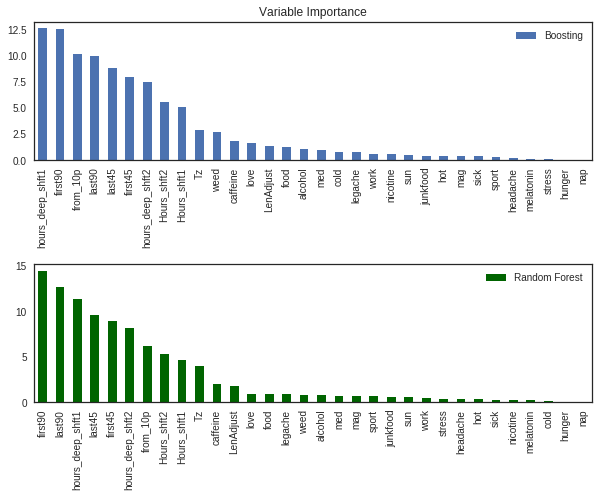

In [60]:
importance = pd.DataFrame({'boosting':gbr.feature_importances_*100,
                           'rf':rfr.feature_importances_*100}, index=X_dr.columns)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,7))
importance.sort_values('boosting', axis=0, ascending=False, inplace=True)
importance.boosting.plot(kind='bar', ax=ax1, label='Boosting')
ax1.set_title('Variable Importance')

importance.sort_values('rf', axis=0, ascending=False, inplace=True)
importance.rf.plot(kind='bar', ax=ax2, color='darkgreen', label='Random Forest')
ax1.legend()
ax2.legend()

plt.subplots_adjust(hspace=0.75);

Feature importance in scikit-learn:
* from https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined:
> * also called _gini importance_ or _mean decrease impurity_
> * defined as the total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble
* from http://blog.datadive.net/interpreting-random-forests/:
> * computes the amount of "impurity" (typically variance in case of regression trees / gini coefficient or entropy in case of classification trees) each feature removes when it is used in the node
> * useful but gives little insight in understanding individual decisions on actual data

### Treeinterpreter (Contribution Plots)

In [61]:
from treeinterpreter import treeinterpreter as ti

prediction, bias, contributions = ti.predict(rfr, X_dt)

From http://blog.datadive.net/interpreting-random-forests/:

> When considering a decision tree, it is intuitively clear that for each decision that a tree (or a forest) makes there is a path (or paths) from the root of the tree to the leaf, consisting of a series of decisions, guarded by a particular feature, each of which contribute to the final predictions.

> Since each decision is guarded by a feature, and the decision either adds or subtracts from the value given in the parent node, the prediction can be defined as the sum of the feature contributions + the “bias” (i.e. the mean given by the topmost region that covers the entire training set).

> The prediction function can be written down as 
> $$f(x) = c_{full} + \sum^K_{k=1}{contrib(x,k)},$$
> where $K$ is the number of features, 
> $c_{full}$ is the value at the root of the node, and 
> $contrib(x,k)$ is the contribution from the k-th feature in the feature vector x. 
> 
> This is superficially similar to linear regression $f(x)=a+bx$:
> * For linear regression the coefficients b are fixed, with a single constant for every feature that determines the contribution
> * For the decision tree, the contribution of each feature is not a single predetermined value, but depends on the rest of the feature vector which determines the decision path that traverses the tree and thus the guards/contributions that are passed along the way

> The prediction of a forest is the average of the predictions of its trees:
> $$F(x) = \frac{1}{J} \sum^J_{j=1}{f_j(x)},$$
> where $J$ is the number of trees in the forest.
> 
> From this, the prediction is simply the average of the bias terms + the average contribution of each feature:
> $$F(x) = \frac{1}{J} \sum^J_{j=1}{c_{j_{full}}} + \sum^K_{k+1} (\frac{1}{J} \sum^J_{j=1}{contrib_j(x,k))}$$

Every prediction can be trivially presented as a sum of feature contributions, showing how the features lead to a particular prediction.

In [62]:
# show as an example for the max predicted value
max_index = np.argmax(prediction)

# compare true value to predicted value
print('True values:', y_dt[max_index])
print('Predicted values:', rfr.predict(X_dt.iloc[max_index,:].values.reshape(1, -1)))

# predicted value as a sum of bias and feature contributions
print('Prediction as a sum of feature contributions:', bias[max_index] + np.sum(contributions[max_index]))

True values: 4.98795204
Predicted values: [ 4.9688432]
Prediction as a sum of feature contributions: 4.96884320359


In [63]:
df_ti = pd.DataFrame({'true': y_dt, 'predicted': prediction[:, 0], 'bias': bias, 'ind': np.arange(prediction.shape[0])})
df_contrb = df_ti.join(pd.DataFrame(contributions, index=np.arange(prediction.shape[0])), on='ind')
df_contrb.sort_values('predicted', axis=0, inplace=True)

bias term: 3.74528811863
mean of top 10 predicted values: 4.829006133618776
mean of bottom 10 predicted values: 3.2026617448101335


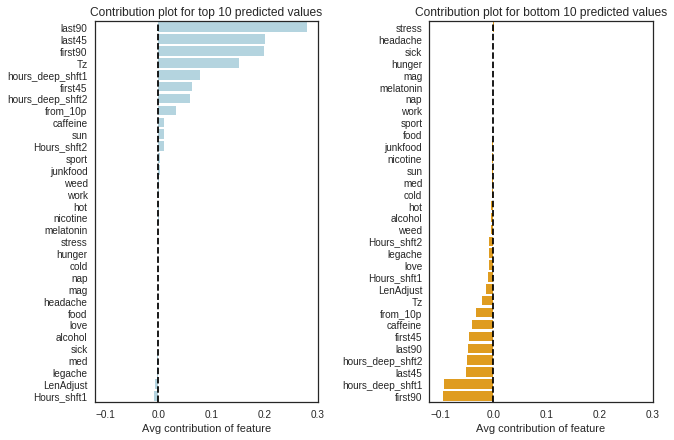

In [64]:
# bottom 10 predicted values
df_min = df_contrb.iloc[:10, 4:].T
df_min.set_index(X_dt.columns, inplace=True)
df_min['avg'] = np.mean(df_min, axis=1)
df_min.sort_values('avg', ascending=False, inplace=True)

# top 10 predicted values
df_max = df_contrb.iloc[-10:, 4:].T
df_max.set_index(X_dt.columns, inplace=True)
df_max['avg'] = np.mean(df_max, axis=1)
df_max.sort_values('avg', ascending=False, inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
sns.barplot(df_max.avg, df_max.index, ax=ax1, color='lightblue')
ax1.set_title('Contribution plot for top 10 predicted values')

sns.barplot(df_min.avg, df_min.index, ax=ax2, color='orange')
ax2.set_title('Contribution plot for bottom 10 predicted values')

for ax in fig.axes:
    ax.set_xlabel('Avg contribution of feature')
    ax.axvline(x=0, linestyle='dashed', color='k');
    ax.set_xlim(-0.12, 0.3)

plt.subplots_adjust(wspace=0.5);

print('bias term:', bias[0]) # bias terms are the same for all X_dt values
print('mean of top 10 predicted values:', df_contrb.iloc[-10:, :].predicted.mean())
print('mean of bottom 10 predicted values:', df_contrb.iloc[:10, :].predicted.mean())

Shown above are average contribution plots for:
1. Top 10 predicted values
    * Top positive contributions come from measures of movement and `hours_deep_shft1`
2. Bottom 10 predicted values
    * Similarly, `first90` and `hours_deep_shft1` contribute the most

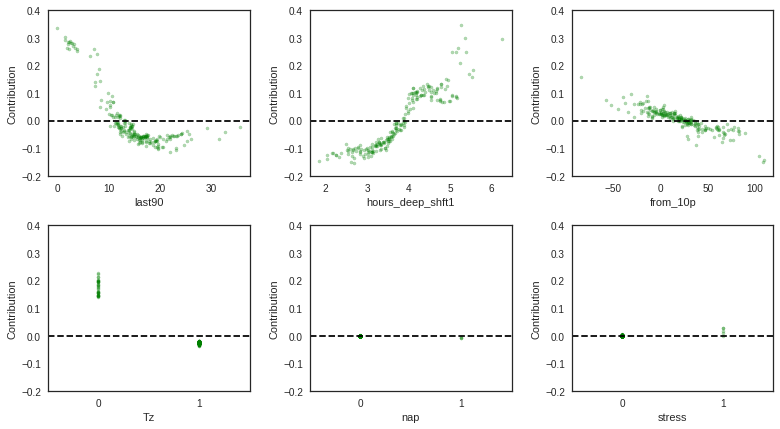

In [65]:
contrb = pd.DataFrame(contributions.T, index=X_dt.columns)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(13, 7))

features = ['last90','hours_deep_shft1', 'from_10p', 'Tz', 'nap', 'stress']

for ax, feature in zip(fig.axes, features):
    ax.scatter(X_dt[feature], contrb.T[feature], alpha=0.3, color='green', s=10)
    sns.regplot(X_dt[feature], contrb.T[feature], scatter=False, fit_reg=False, ax=ax)

    ax.set_ylabel('Contribution')
    ax.set_ylim(-0.2, 0.4)
    ax.axhline(linestyle='dashed', color='k');
    
for ax in (ax4, ax5, ax6):
    ax.set_xticks([0, 1])
    ax.set_xlim(-0.5, 1.5)
plt.subplots_adjust(wspace=0.3, hspace=0.3);

Shown above are contribution plots for 6 features, which show the feature contribution at each observation:
1. `last90`: 
    * As evident by the initial steep slope, increasing `last90` corresponds to a lower contribution (to deep sleep) up to a certain point 
    * Since `last90` is a measure of movement in the last 90 minutes of sleep, it makes sense that less movement corresponds to more deep sleep
    * However, past `last90` $\approx$ 15, more movement does _not_ mean less deep sleep
    
2. `hours_deep_shft1`: 
    * There is an increasing relationship between hours of deep sleep from one day ago and hours of deep sleep
    * As seen in the exploratory analysis, there tends to be stretches of good sleep periods

3. `from_1op`: 
    * Later bedtimes are associated with less deep sleep

4. `Tz`:
    * PT (`TZ` = 0) contributes positively to deep sleep, whereas ET (`TZ` = 1) negatively contributes
    
5. User tags: `#nap` and `#stress`
    * Barely any difference in deep sleep on days tagged with nap or stress -- the difference observed was much more prominent in the box plot during exploratory analysis

# Summary: Deep Sleep Predictive Models

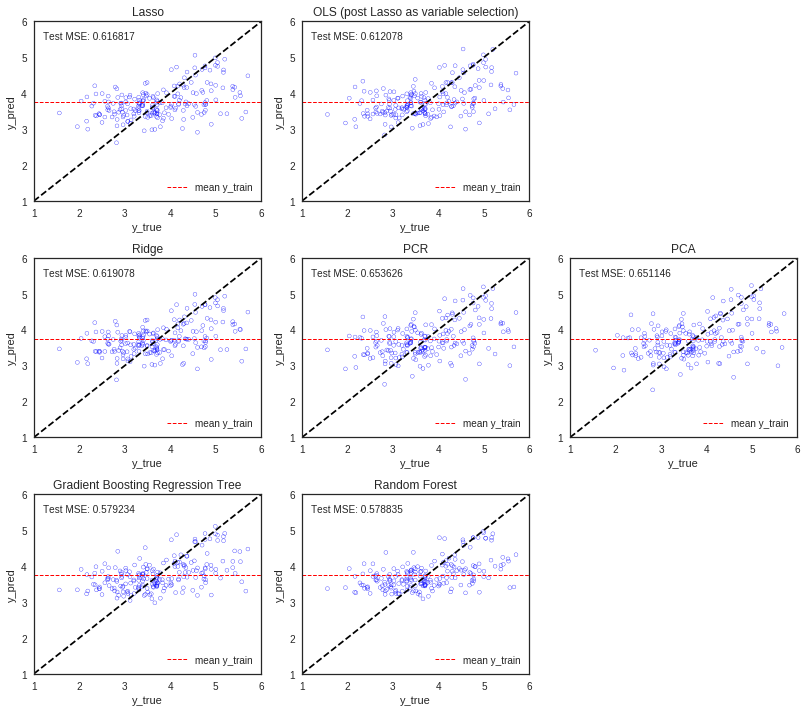

In [66]:
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(3,4)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])
ax5 = plt.subplot(gs[1,2])
ax6 = plt.subplot(gs[2,0])
ax7 = plt.subplot(gs[2,1])

for ax, ypred in zip([ax1, ax2, ax3, ax4, ax5, ax6, ax7], [lasso_y, ols_y, ridge_y, pca_y, pls_y, gbr_y, rfr_y]):
    #ax.scatter(ypred, y_dt - ypred, facecolor='None', edgecolor='blue', s=15 )
    #sns.regplot(ypred, y_dt - ypred, scatter=False, lowess=True, ax=ax, line_kws={'color': 'r', 'lw':1})
    ax.scatter(y_dt, ypred, facecolor='None', edgecolor='blue', s=15 )
    ax.text(1.2, 5.5, ('Test MSE: {:4g}'.format(mean_squared_error(y_dt, ypred))))
    
ax1.set_title('Lasso')
ax2.set_title('OLS (post Lasso as variable selection)')
ax3.set_title('Ridge')
ax4.set_title('PCR')
ax5.set_title('PCA')
ax6.set_title('Gradient Boosting Regression Tree')
ax7.set_title('Random Forest')

for ax in fig.axes:
    ax.plot([0,1], [0,1], '--k', transform=ax.transAxes)
    ax.axhline(np.mean(y_dr), linewidth=1, linestyle='dashed', color='red', label='mean y_train')
    ax.legend(loc=4)
    ax.set_xlabel('y_true')
    ax.set_xlim(1, 6)
    ax.set_ylabel('y_pred')
    ax.set_ylim(1, 6)
    
gs.tight_layout(plt.gcf());

In [67]:
# average deep sleep in hours & minutes
np.mean(y_d), np.mean(y_d) * 60

(3.7414316269693906, 224.48589761816345)

In [68]:
# root mean square error (in minutes) of predicted y values from the lowest test MSE model
60 * np.sqrt(mean_squared_error(y_dt, rfr_y)) 

45.648706585230904

In [69]:
# root mean squre error (in minutes) of predicted y values (mean) from the baseline model
60 * np.sqrt(np.mean((y_dt - np.mean(y_dr))**2))

52.331185766949766

1. All models are pretty terrible at predicting deep sleep, with the predicted values hovering around the mean
2. All models have a particularly hard time predicting the lower end of deep sleep, but perform better at predicting the higher values
3. The best test MSE was obtained from random forest:
    * RMSE from the trained model is 45.65 min, whereas the baseline model which simply uses the mean of the training data as the predicted values yields an RMSE of 52.33 min
    * The gradient boost model is more accurate by 6.7 minutes, which is a 13% improvement
    * Given that the avg deep sleep is 3.7 hrs or 224.5 minutes, RMSE of 45.65 minutes is very large 

# "Above Average" Sleep Rating Classification

## Logistic Regression

In [70]:
logisticcv = LogisticRegressionCV(solver='liblinear', cv=10, max_iter=10000, penalty='l1', class_weight='balanced')
logisticcv.fit(scale(X_rr), y_rr)
np.mean(cross_val_score(logisticcv, scale(X_rr), y_rr, scoring='roc_auc', cv=10)) # CV roc_auc

0.68371665429731787

In [71]:
logistic_y_pred = logisticcv.predict(scale(X_rt))
logistic_y_prob = logisticcv.predict_proba(scale(X_rt))
roc_auc_score(y_rt, logistic_y_prob[:, 1]) # test roc_auc

0.66319372807922439

In [72]:
pd.DataFrame({'Predicted': logistic_y_pred, 'True': y_rt}).groupby(['Predicted', 'True']).size().unstack('True')

True,0,1
Predicted,,
0,81,30
1,50,44


In [73]:
logistic_tpr = 44 / (30 + 44)
logistic_fpr = 50 / (81 + 50)
logistic_precision = 44 / (50 + 44)

In [74]:
lr = pd.DataFrame({'coeff':logisticcv.coef_[0], 'std':np.std(X_rr)}, 
                   index=X_rr.columns)
lr['abs_coeff'] = np.abs(lr.coeff)
lr.sort_values('abs_coeff', ascending=False, inplace=True)
del lr['abs_coeff']
lr

,coeff,std
last90,-0.416289,5.801404
alcohol,-0.343371,0.268648
legache,-0.332642,0.379583
hot,-0.310873,0.126677
hours_deep,0.236760,0.912774
nap,-0.226430,0.089945
Cycles,0.209081,1.509211
sport,-0.199351,0.435572
Hours,0.186893,0.705471
first90,-0.185983,4.070124


## Gradient Boosting Classification Trees

In [75]:
# Baseline model
gbc0 = GradientBoostingClassifier(random_state=634).fit(X_rr, y_rr)
np.mean(cross_val_score(gbc0, X_rr, y_rr, cv=10, scoring='roc_auc'))

0.63074259900632901

In [76]:
roc_auc_score(y_rt, gbc0.predict_proba(X_rt)[:, 1]) # baseline test roc_auc

0.63410356921807309

In [77]:
gbc_model = Pipeline([
    ('gbc', GradientBoostingClassifier(random_state=634))
])

In [78]:
# parameters after training
gbc_hyper_params = {
                    'gbc__learning_rate': [0.03],
                    'gbc__n_estimators': [250],
                    'gbc__max_depth': [3],
                    'gbc__min_samples_split': [10],
                    'gbc__min_samples_leaf': [1],
                    'gbc__max_features': [7],
                    'gbc__subsample': [0.85]
                   }

In [79]:
gbc_cv = GridSearchCV(gbc_model, param_grid=gbc_hyper_params, cv=10, scoring='roc_auc')
gbc_cv.fit(X_rr, y_rr)
gbc_cv.best_params_, gbc_cv.best_score_ # CV roc_auc after training

({'gbc__learning_rate': 0.03,
  'gbc__max_depth': 3,
  'gbc__max_features': 7,
  'gbc__min_samples_leaf': 1,
  'gbc__min_samples_split': 10,
  'gbc__n_estimators': 250,
  'gbc__subsample': 0.85},
 0.67489761404410065)

In [80]:
gbc_y_pred = gbc_cv.predict(X_rt)
gbc_y_prob = gbc_cv.predict_proba(X_rt)[:, 1]
roc_auc_score(y_rt, gbc_y_prob) # test roc_auc after training

0.66505054672993613

In [81]:
pd.DataFrame({'Predicted': gbc_y_pred, 'True': y_rt}).groupby(['Predicted', 'True']).size().unstack('True')

True,0,1
Predicted,,
0,98,39
1,33,35


In [82]:
gbc_tpr = 35 / (39 + 35)
gbc_fpr = 33 / (98 + 33)
gbc_precision = 35 / (33 + 35)

In [83]:
# for feature importance
gbc = GradientBoostingClassifier(learning_rate=0.03, n_estimators=250, max_depth=3, min_samples_split=10, min_samples_leaf=1, max_features=7, subsample=0.85, random_state=634).fit(X_rr, y_rr)

## Random Forest

In [84]:
# Baseline model
rfc0 = RandomForestClassifier(random_state=34).fit(X_rr, y_rr)
np.mean(cross_val_score(rfc0, X_rr, y_rr, cv=10, scoring='roc_auc'))

0.60982184272373063

In [85]:
roc_auc_score(y_rt, rfc0.predict_proba(X_rt)[:, 1]) # baseline test roc_auc

0.62554157210645756

In [86]:
rfc_model = Pipeline([
    ('rfc', RandomForestClassifier(random_state=34))
])

In [87]:
# parameter training
rfc_hyper_params = {
                    'rfc__n_estimators': [600], 
                    'rfc__max_features': [1],
                    'rfc__min_samples_leaf': [2],
                    'rfc__min_samples_split': [2],
                   }

In [88]:
rfc_cv = GridSearchCV(rfc_model, param_grid=rfc_hyper_params, cv=10, scoring='roc_auc')
rfc_cv.fit(X_rr, y_rr)
rfc_cv.best_params_, rfc_cv.best_score_ # CV roc_auc after training

({'rfc__max_features': 1,
  'rfc__min_samples_leaf': 2,
  'rfc__min_samples_split': 2,
  'rfc__n_estimators': 600},
 0.6831031030283683)

In [89]:
rfc_y_pred = rfc_cv.predict(X_rt)
rfc_y_prob = rfc_cv.predict_proba(X_rt)[:, 1]
roc_auc_score(y_rt, rfc_y_prob) # test roc_auc after training

0.66432845058799261

In [90]:
pd.DataFrame({'Predicted': rfc_y_pred, 'True': y_rt}).groupby(['Predicted', 'True']).size().unstack('True')

True,0,1
Predicted,,
0,124,52
1,7,22


In [91]:
rfc_tpr = 22 / (52 + 22)
rfc_fpr = 7 / (124 + 7)
rfc_precision = 22 / (7 + 22)

In [92]:
# for feature importance
rfc = RandomForestClassifier(random_state=34, n_estimators=600, max_features=1, min_samples_leaf=2, min_samples_split=2).fit(X_rr, y_rr)

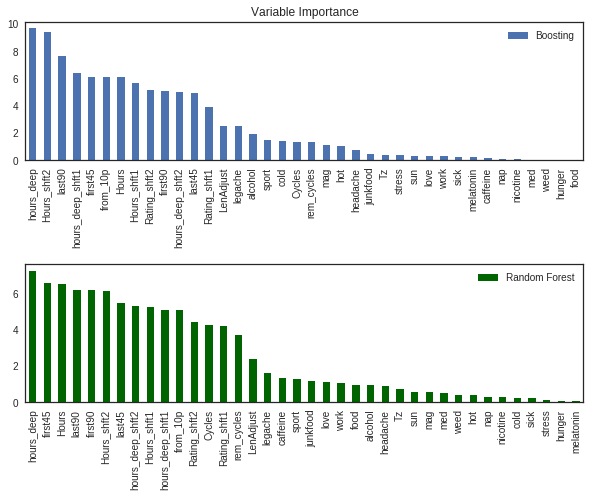

In [93]:
importance = pd.DataFrame({'boosting':gbc.feature_importances_*100,
                           'rf':rfc.feature_importances_*100}, index=X_rr.columns)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,7))
importance.sort_values('boosting', axis=0, ascending=False, inplace=True)
importance.boosting.plot(kind='bar', ax=ax1, label='Boosting')
ax1.set_title('Variable Importance')

importance.sort_values('rf', axis=0, ascending=False, inplace=True)
importance.rf.plot(kind='bar', ax=ax2, color='darkgreen', label='Random Forest')
ax1.legend()
ax2.legend()

plt.subplots_adjust(hspace=0.75);

### Treeinterpreter (Contribution Plots)

In [94]:
prediction2, bias2, contributions2 = ti.predict(rfc, X_rt) # running treeinpterpreter to get contributions

In [95]:
# similarly as before, show as an example for the max predicted probability of being classified as 1 (above 3.5 rating)
max_index = np.argmax(prediction2[0:, 1])

# compare true class to predicted class; also show predicted probability
print('True class:', y_rt[max_index])
print('Predicted class & score:', rfc.predict(X_rt.iloc[max_index, :].values.reshape(1, -1)), rfc.predict_proba(X_rt.iloc[max_index, :].values.reshape(1, -1))[:, 1])

# predicted probability as a sum of bias and feature contributions
print('Prediction as a sum of feature contributions:', bias2[max_index, 1] + np.sum(contributions2[max_index, :, 1]))

True class: 1
Predicted class & score: [1] [ 0.62462245]
Prediction as a sum of feature contributions: 0.624622446918


In [96]:
df_ti = pd.DataFrame({'true_class': y_rt, 'predicted_prob': prediction2[:, 1], 'ind': np.arange(prediction2.shape[0])})
df_ti['predicted_class'] = np.where(df_ti.predicted_prob > 0.5, 1, 0)
df_contrb = df_ti.join(pd.DataFrame(contributions2[:, :, 1], index=np.arange(prediction2.shape[0])), on='ind')
df_contrb.sort_values('predicted_prob', axis=0, inplace=True)

bias term: 0.386911364872
mean of predicted class 1 probs: 0.5353251870665781
mean of predicted class 0 probs: 0.37194522278474873


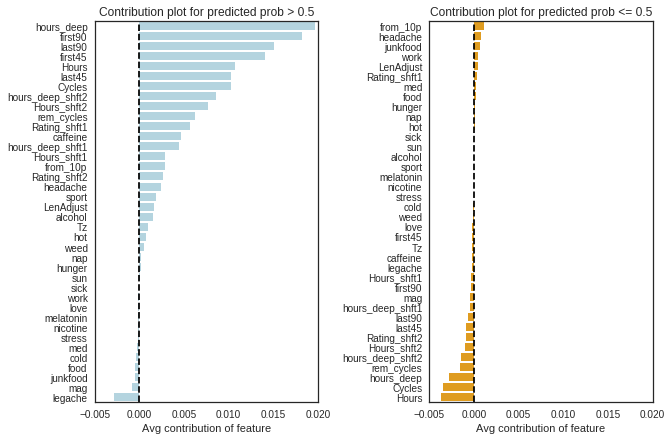

In [97]:
# index where predicted_class > 0.5
threshold_index = np.int(np.searchsorted(df_contrb.predicted_prob, 0.5))

# predicted class = 0
df_0 = df_contrb.iloc[:threshold_index, 4:].T
df_0.set_index(X_rt.columns, inplace=True)
df_0['avg'] = np.mean(df_0, axis=1)
df_0.sort_values('avg', ascending=False, inplace=True)

# predicted class = 1
df_1 = df_contrb.iloc[threshold_index:, 4:].T
df_1.set_index(X_rt.columns, inplace=True)
df_1['avg'] = np.mean(df_1, axis=1)
df_1.sort_values('avg', ascending=False, inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
sns.barplot(df_1.avg, df_1.index, ax=ax1, color='lightblue')
ax1.set_title('Contribution plot for predicted prob > 0.5')

sns.barplot(df_0.avg, df_0.index, ax=ax2, color='orange')
ax2.set_title('Contribution plot for predicted prob <= 0.5')

for ax in fig.axes:
    ax.set_xlabel('Avg contribution of feature')
    ax.axvline(x=0, linestyle='dashed', color='k');
    ax.set_xlim(-0.005, 0.02)

plt.subplots_adjust(wspace=0.5);

print('bias term:', bias2[0, 1]) # bias terms are the same for all X_rt values
print('mean of predicted class 1 probs:', df_contrb.iloc[threshold_index:, :].predicted_prob.mean())
print('mean of predicted class 0 probs:', df_contrb.iloc[:threshold_index, :].predicted_prob.mean())

Plots above show that top contributions come from features related to hours of sleep (`hours_deep`, `Hours`, `Cycles`) and measure of movement

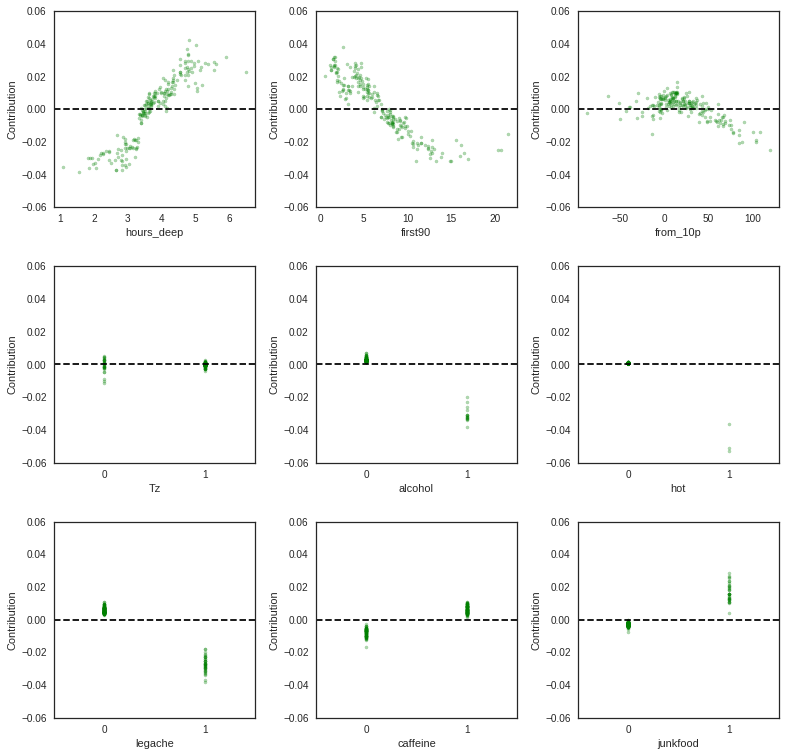

In [98]:
contrb = pd.DataFrame(contributions2[:, :, 1].T, index=X_rt.columns)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(13, 13))

features = ['hours_deep', 'first90', 'from_10p', 'Tz', 'alcohol', 'hot', 'legache', 'caffeine', 'junkfood']

for ax, feature in zip(fig.axes, features):
    ax.scatter(X_rt[feature], contrb.T[feature], alpha=0.3, color='green', s=10)
    sns.regplot(X_rt[feature], contrb.T[feature], scatter=False, fit_reg=False, ax=ax)

    ax.set_ylabel('Contribution')
    ax.set_ylim(-0.06, 0.06)
    ax.axhline(linestyle='dashed', color='k');
    
for ax in (ax4, ax5, ax6, ax7, ax8, ax9):
    ax.set_xticks([0, 1])
    ax.set_xlim(-0.5, 1.5)
plt.subplots_adjust(wspace=0.3, hspace=0.3);

Shown above are contribution plots for 6 features, which show the feature contribution at each observation:
* As `hours_deep` increases, the probability of sleep being rated higher than 3.5 also increases
* Measurements of movement and sleep rating are negatively correlated
* Going to bed 50 minues past 10 pm negatively affects sleep rating
* As observed during exploratory analysis, timezone doesn't play much of a role in sleep rating
* Days tagged with `#alcohol`, `#headache`, and `#legache` do worse in sleep rating, whereas `#caffeine` and `#junkfood` have higher probabilities of good sleep rating

# Summary:  Sleep Rating Predictive Models

In [99]:
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve

In [100]:
def plot_curves(y_true, y_prob, fpr_, tpr_, precision_, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(title, fontsize='x-large')
    
    # false/true positive rates for different classification thresholds
    fpr, tpr, threshold = roc_curve(y_true, y_prob, drop_intermediate=False)
    roc_auc = auc(fpr, tpr)

    # plot ROC curve
    ax1.set_title('ROC Curve: AUC={0:0.4f}'.format(roc_auc))
    ax1.step(fpr, tpr, 'b', where='post')
    ax1.fill_between(fpr, tpr, step='post', alpha=0.1, color='b')
    ax1.plot(fpr_, tpr_, 'yD', markersize=8, label='at threshold=0.5')
    ax1.annotate('({:.2f}, {:.2f})'.format(fpr_, tpr_), xy=(fpr_, tpr_), xytext=(fpr_ + 0.03, tpr_ - 0.03))
    ax1.plot([0, 1],[0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1.01])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    ax1.legend(loc=4)
    
    average_precision = average_precision_score(y_true, y_prob)
    # precision/recall for different classification thresholds
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    
    # plot PRC curve
    ax2.set_title('Precision-Recall Curve: AUC={0:0.4f}'.format(average_precision)) 
    ax2.step(recall, precision, color='b', where='post')
    ax2.fill_between(recall, precision, step='post', alpha=0.1, color='b')
    ax2.axhline(0.5, color='r', linestyle='dashed')
    ax2.plot(tpr_, precision_, 'yD', markersize=8, label='at threshold=0.5')
    ax2.annotate('({:.2f}, {:.2f})'.format(tpr_, precision_), xy=(tpr_, precision_), 
                 xytext=(tpr_ + 0.03, precision_ + 0.03))
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_ylim([0.0, 1.01])
    ax2.set_xlim([0.0, 1.0])
    ax2.legend(loc=4)

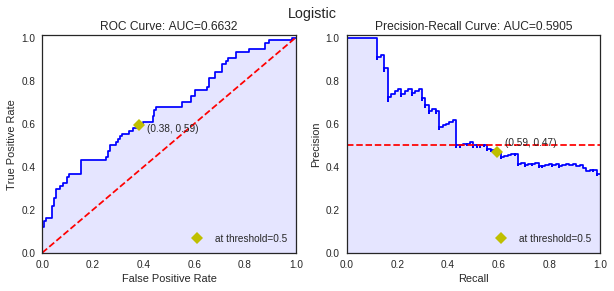

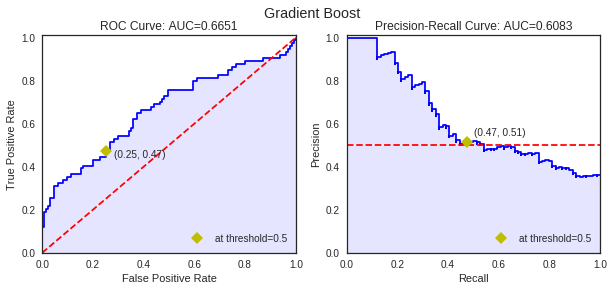

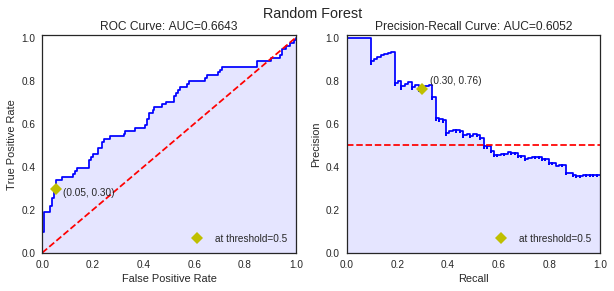

In [101]:
plot_curves(y_rt, logistic_y_prob[:, 1], logistic_fpr, logistic_tpr, logistic_precision, 'Logistic')
plot_curves(y_rt, gbc_y_prob, gbc_fpr, gbc_tpr, gbc_precision, 'Gradient Boost')
plot_curves(y_rt, rfc_y_prob, rfc_fpr, rfc_tpr, rfc_precision, 'Random Forest')

In [102]:
# accuracy scores
accuracy_score(y_rt, logistic_y_pred), accuracy_score(y_rt, gbc_y_pred), accuracy_score(y_rt, rfc_y_pred)

(0.6097560975609756, 0.64878048780487807, 0.71219512195121948)

* While AUCs are neck-and-neck among the three models, gradient boosting comes out slightly ahead for both ROC and precision-recall curves
* At threshold=0.5:
    1. Logistic regression has the highest true positive rate but also the highest false positive rate
    2. The random forest model has the lowest false positve rate while sacrificing a lot in true positive rate; its precision and accuracy are high
* No clear winner